# COMP90051 Project 2

In [348]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [349]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [350]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    
    """
    Epsilon - Greedy:
    parameters: 1. narms: number of arms
                2. epsilon
                3. Q0 
    Working:    1. narms is the number of distinct arms in data
                2. Array q of size narms is created with all values assigned to infinity
                3. An array play_count of size narms with all values assigned to 0
    
    
    """
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        self.q = [self.Q0 for col in range(self.narms)]
        self.play_count = [0 for col in range(self.narms)]
        
        
    """
    Parameter: 1. tround: round number
               2. contexts(unused)
               
    Working:   1. Takes random values and compares with epsilon values, if less than epsilon it returns a random value
                   If more than epsilon it returns the arm with maximum value of q for that arm
               2. Epsilon handles exploration and 1- Epsilon handles exploitaion
    Return :   index of q with max value +1 as the array starts from 0
    """ 
        
    def play(self, tround, context=None):
        #self.tround = 1 + tround
        rand_num = np.random.random_sample()
        if rand_num < 1 - self.epsilon:
            arms1 = np.random.uniform(0,self.narms + 1)
            return arms1   
        else:
            n = np.argmax(self.q)
            return n+1
        
        
    """
    Parameter: 1. arm: arm selected from play function
               2. reward: reward of the event which matched the arm
               
    Working:   1. Updates the value of q for the particular arm that is given in the 
                  argument with the reward for that event   
    """
    def update(self, arm, reward, context=None):
        self.play_count[arm-1] =self.play_count[arm-1] +1
        n = self.play_count[arm-1]
        new_Q = reward/self.play_count[arm-1]
        self.q[arm-1] = new_Q
        
            
        
        
    

In [351]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    """
    UCB Initialization:
    parameters: 1. narms: number of arms
                2. rho
                3. Q0
                
    Working:    1. Array Q of size narms is created with all values assigned to infinity
                2. An array play_count of size narms with all values assigned to 0
    
    """
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.Q = [self.Q0 for col in range(narms)]
        self.play_count = [0.0 for col in range(narms)]
        self.round = 0
        
    """
    Parameter: 1. tround: round number
               2. contexts(unused)
               
    Working:    Initialize the current round
    
    Return:     Sends the arm with max value from Q array by taking the index of maximum value from Q 
    """
    def play(self, tround, context=None):
        self.round =  tround
        n = np.argmax(self.Q)
        return n+1             #+1 as arms are from 1-10 and array is 0-9
        
    """
    Parameter: 1. arm: arm selected from play function
               2. reward: reward of the event which matched the arm
                   
    Working:   1. Increasses the count of particular arm
               2. Updates the Q value for the particuar arm given by formula mentioned in slides
    """
    def update(self, arm, reward, context=None):
        self.play_count[arm - 1] =self.play_count[arm - 1] +1
        n = self.play_count[arm-1]
        new_Q = (reward/self.play_count[arm-1]) + np.sqrt(self.rho*np.log((self.round)/self.play_count[arm-1]))
        self.Q[arm-1] = new_Q
        
        
        
    

In [352]:
"""
Reading data:
Split the data and assign into three arrays arms, rewards, contexts
"""
data = open("dataset.txt",'r')
arms = []
rewards =[]
contexts =[]
for x in data:
	row = x.split()
	t1 = int(row[0])
	t2 = int(row[1])
	arms.append(t1)
	rewards.append(t2)
	contexts.append([int(y) for y in row[2:]if y])
    

## 2. Off-Policy Evaluation

In [353]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    
    """
    Offline Evaluation:
    
    Working: 1. Checks if the number of round does not exceed the rounds given
             2. The code runs for each event from the data 
             3. Uses play function of policies to recieve an arm 
             4. If arm is present in the list of arms from the data, add the reward of that event to history
             5. Call the update function of policies 
             6. update tround as length of history which is the number of rounds played
             
    Returns: array history containing rewards
    
    """
    history=[]           # an array to store the rewards from the events
    tround = 1           # round number starts from 1 - nrounds
    for i in range(len(arms)):
        if(tround > nrounds):
            break
        else:    
            armID=mab.play(tround,contexts[i])       #armID takes the arm from play function of policies
            if(armID in arms):
                history.append(rewards[i])
                mab.update(armID -1,rewards[i],contexts[i])      #calls the update function of policies to update the
                                                                #Q value of that arm
                tround = len(history) +1                       # update tround with the length of history
    return history    
            
        
    

In [354]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.09867172675521822


In [355]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.105


In [356]:
"""
Take contexts as argument and returns an array of 1D vector by dividing the data into 10 equal parts
"""
def MakeMatrix(contexts):
    a1 = np.array(contexts[0:10])
    x1 = np.mat(a1).T
    a2 = np.array(contexts[10:20])
    x2 = np.mat(a2).T
    a3 = np.array(contexts[20:30])
    x3 = np.mat(a3).T
    a4 = np.array(contexts[30:40])
    x4 = np.mat(a4).T
    a5 = np.array(contexts[40:50])
    x5 = np.mat(a5).T
    a6 = np.array(contexts[50:60])
    x6 = np.mat(a6).T
    a7 = np.array(contexts[60:70])
    x7 = np.mat(a7).T
    a8 = np.array(contexts[70:80])
    x8 = np.mat(a8).T
    a9 = np.array(contexts[80:90])
    x9 = np.mat(a9).T
    a10 = np.array(contexts[90:100])
    x10 = np.mat(a10).T
    new_context = [x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]
    return new_context

## 3. Contextual Bandits

In [357]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    
    """
    LinUCB Initialization:
    parameters: 1. narms: number of arms
                2. ndims: Dimensions of matrix
                3. alpha
                
    Working:    1. Initializes Two matrices A and B of size (narms * narms)
    """
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.A = [[]] * narms
        self.B = [[]] * narms
        
        
    """
    Parameters: tround: round number, contexts per event
     Working: 1. checks if the matrices A and B for that arm has been made if not, Initialize matrices
                 A as identity matrix and B as zeroes matrix.
              2. Calculate value of theta = A inv. * B
              3. Call MakeMatrix with contexts as arguments, which returns an array of 10 equally separated
                  1-D vectors
              4. Calculate the payoff for each arm from the formula mentioned in WWW’2010 paper
     Return: the arm with max payoff 
    """
        
    def play(self, tround, context):
        p={}
        for arm in range(self.narms):
            if(len(self.A[arm]) is 0):
                self.A[arm] = np.identity(self.ndims)
                self.B[arm] = np.zeros((self.ndims,1))
            theta = np.matmul(np.linalg.inv(self.A[arm]),self.B[arm])          
            context_matrix = MakeMatrix(context)
            p1 =  theta.T.dot(context_matrix[arm])
            p2 =   context_matrix[arm].T.dot(np.linalg.inv(self.A[arm])).dot(context_matrix[arm])     
            p[arm] = float( p1 + self.alpha * np.sqrt(p2))
        arm123=max(p, key=p.get)
        return arm123 + 1            # + 1 as loop starts from 0
            
                
                
        """
        Prameters: 1. Arm from the play function if matched with the event
                   2. Reward of that particular event
                   3. contexts of that event
                   
        Working:   1. call the MakeMatrix function to make 1-D vectors of contexts
                   2. Update value of A and B of that arm by the formula given in WWW’2010 paper
        """
    
    def update(self, arm, reward, context):
        context_new = MakeMatrix(context)
        self.A[arm] = self.A[arm] + context_new[arm].dot(context_new[arm].T)
        self.B[arm] = self.B[arm] + reward *context_new[arm]
        
    

In [358]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 700)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.10571428571428572


## 4. Evaluation
### 4.A.

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in sqrt
//anaconda/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


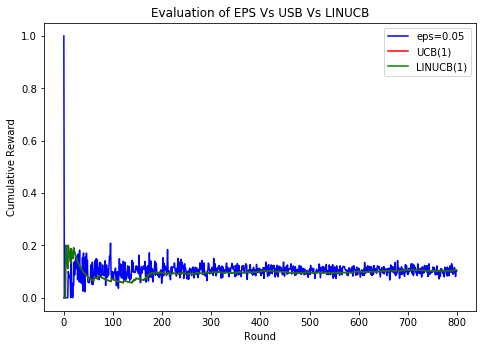

In [331]:
'''
Working: 1. This code runs for a number of games specified by the Games variable and for the number 
            of rounds specified by Rounds.
         2. We make three arrays(EPSRound,UCBRound,LINUCBRound) initialized with zeroes for all three 
            policies to store the result for each round
         3. we start the for loop for the specified number of rounds, call the offlineEvaluate with the round number
            for each policies and store the cumulative reward in an array 
         4. Plot the graph for round VS the cumulative rewards per round
'''
Games=1
Rounds=800
EPSRound=np.zeros(Rounds,dtype=float)
UCBRound=np.zeros(Rounds,dtype=float)
LINUCBRound=np.zeros(Rounds,dtype=float)
rounds=[Rounds for x in range(Games)]
rounds1=[x for x in range(Rounds)]
averageScorePerRound=[]
#print(rounds)
games=[[]]*Games                  #list to store the score per round per game

for i in range(Games):
    epsMab = EpsGreedy(10, 0.05)
    ucbMab = UCB(10, 1.0)
    linUcbMab = LinUCB(10, 10, 1.0)
    for j in range(1,(Rounds+1)):                #start from round 1 as round 0 is the initialization round
        EPSRound[(j-1)]=EPSRound[(j-1)]+np.mean(offlineEvaluate(epsMab, arms, rewards, contexts, j))
        UCBRound[(j-1)]=UCBRound[(j-1)]+np.mean(offlineEvaluate(ucbMab, arms, rewards, contexts, j))
        LINUCBRound[(j-1)]=LINUCBRound[(j-1)]+np.mean(offlineEvaluate(linUcbMab, arms, rewards, contexts, j))






fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])  # left,bottom,width,height(range 0 to 1)

axes.plot(rounds1,EPSRound,'b', label='eps=0.05')
axes.plot(rounds1,UCBRound,'r',label='UCB(1)')
axes.plot(rounds1,LINUCBRound,'g',label='LINUCB(1)')
axes.set_ylabel('Cumulative Reward')
axes.set_xlabel('Round')
axes.set_title('Evaluation of EPS Vs USB Vs LINUCB')
axes.legend(loc=0)
fig.show()

### 4.B.

In [334]:
"""
Working: 1. To optimize LinUCB we change the value of alpha for every run and check which value of alpha gives us the 
            best result.
         2. we make an array alpha and fill it with alpha values with a differece of 0.5 
         3. for each value of alpha we call the LinUCB function with that alpha value and then call offlineEvaluation 
            function and store the values in an array linucb
         4. We then plot the graph for values of alpha to result to see, which value of alpha gives the optimal result
"""
alpha=np.zeros(100,dtype=float)
for i in range(100):
    alpha[i]=alpha[i-1]+0.5

linucb=np.zeros(100,dtype=float)     

for index,value in enumerate(alpha):
    mab = LinUCB(10, 10, value)
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 200)
    linucb[index]=np.mean(results_LinUCB)
    
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])  # left,bottom,width,height(range 0 to 1)

axes.plot(alpha,linucb,'g',label='LINUCB(1)')
#axes.plot(x,y,'b')
axes.set_ylabel('Average Reward')
axes.set_xlabel('alpha value')
axes.set_title('Grid Search for LINUCB')
axes.legend(loc=0)
fig.show()

KeyboardInterrupt: 

## 5. KernelUCB

In [ ]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        
    
    def play(self, tround, context):
        
    
    def update(self, arm, reward, context):
        
    